In [1]:
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


import xgboost as xgb

import numpy as np

  ### Preprocessing

In [2]:
!pip install yfinance

!pip install hpbandster-sklearn

In [3]:
# Load data
import yfinance as yf

btcdata = yf.download("ETH-USD", start="2020-04-01", end="2022-04-07")
df = pd.DataFrame(btcdata)
df.drop(columns=['Adj Close'],inplace=True)


df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2020-04-01,133.612320,135.634552,129.730942,135.634552,12456564435
2020-04-02,135.732178,146.787094,135.732178,142.029144,15322861686
2020-04-03,142.110458,146.899872,139.619385,142.091309,13184603402
2020-04-04,142.215179,145.377304,140.121826,145.219391,11946658257
2020-04-05,145.261017,146.128525,142.102081,143.546646,11280993591
...,...,...,...,...,...
2022-04-03,3444.810547,3573.960205,3421.259766,3522.833496,15333808649
2022-04-04,3522.364990,3535.148193,3422.000977,3521.241211,18209969743
2022-04-05,3521.239746,3546.706787,3410.547607,3411.792480,16681503199


In [4]:
# Define features set
df['Open']=df.Open.shift(-1)
df['High']=df.High.shift(-1)
df['Low']=df.Low.shift(-1)
df['Volume']=df.Low.shift(-1)
df.dropna(inplace=True)
X.drop("Close", axis=1, inplace=True)
X.head()

,Open,High,Low,Volume
Date,,,,
2020-04-01,133.612320,135.634552,129.730942,12456564435
2020-04-02,135.732178,146.787094,135.732178,15322861686
2020-04-03,142.110458,146.899872,139.619385,13184603402
2020-04-04,142.215179,145.377304,140.121826,11946658257
2020-04-05,145.261017,146.128525,142.102081,11280993591


<AxesSubplot:xlabel='Date'>

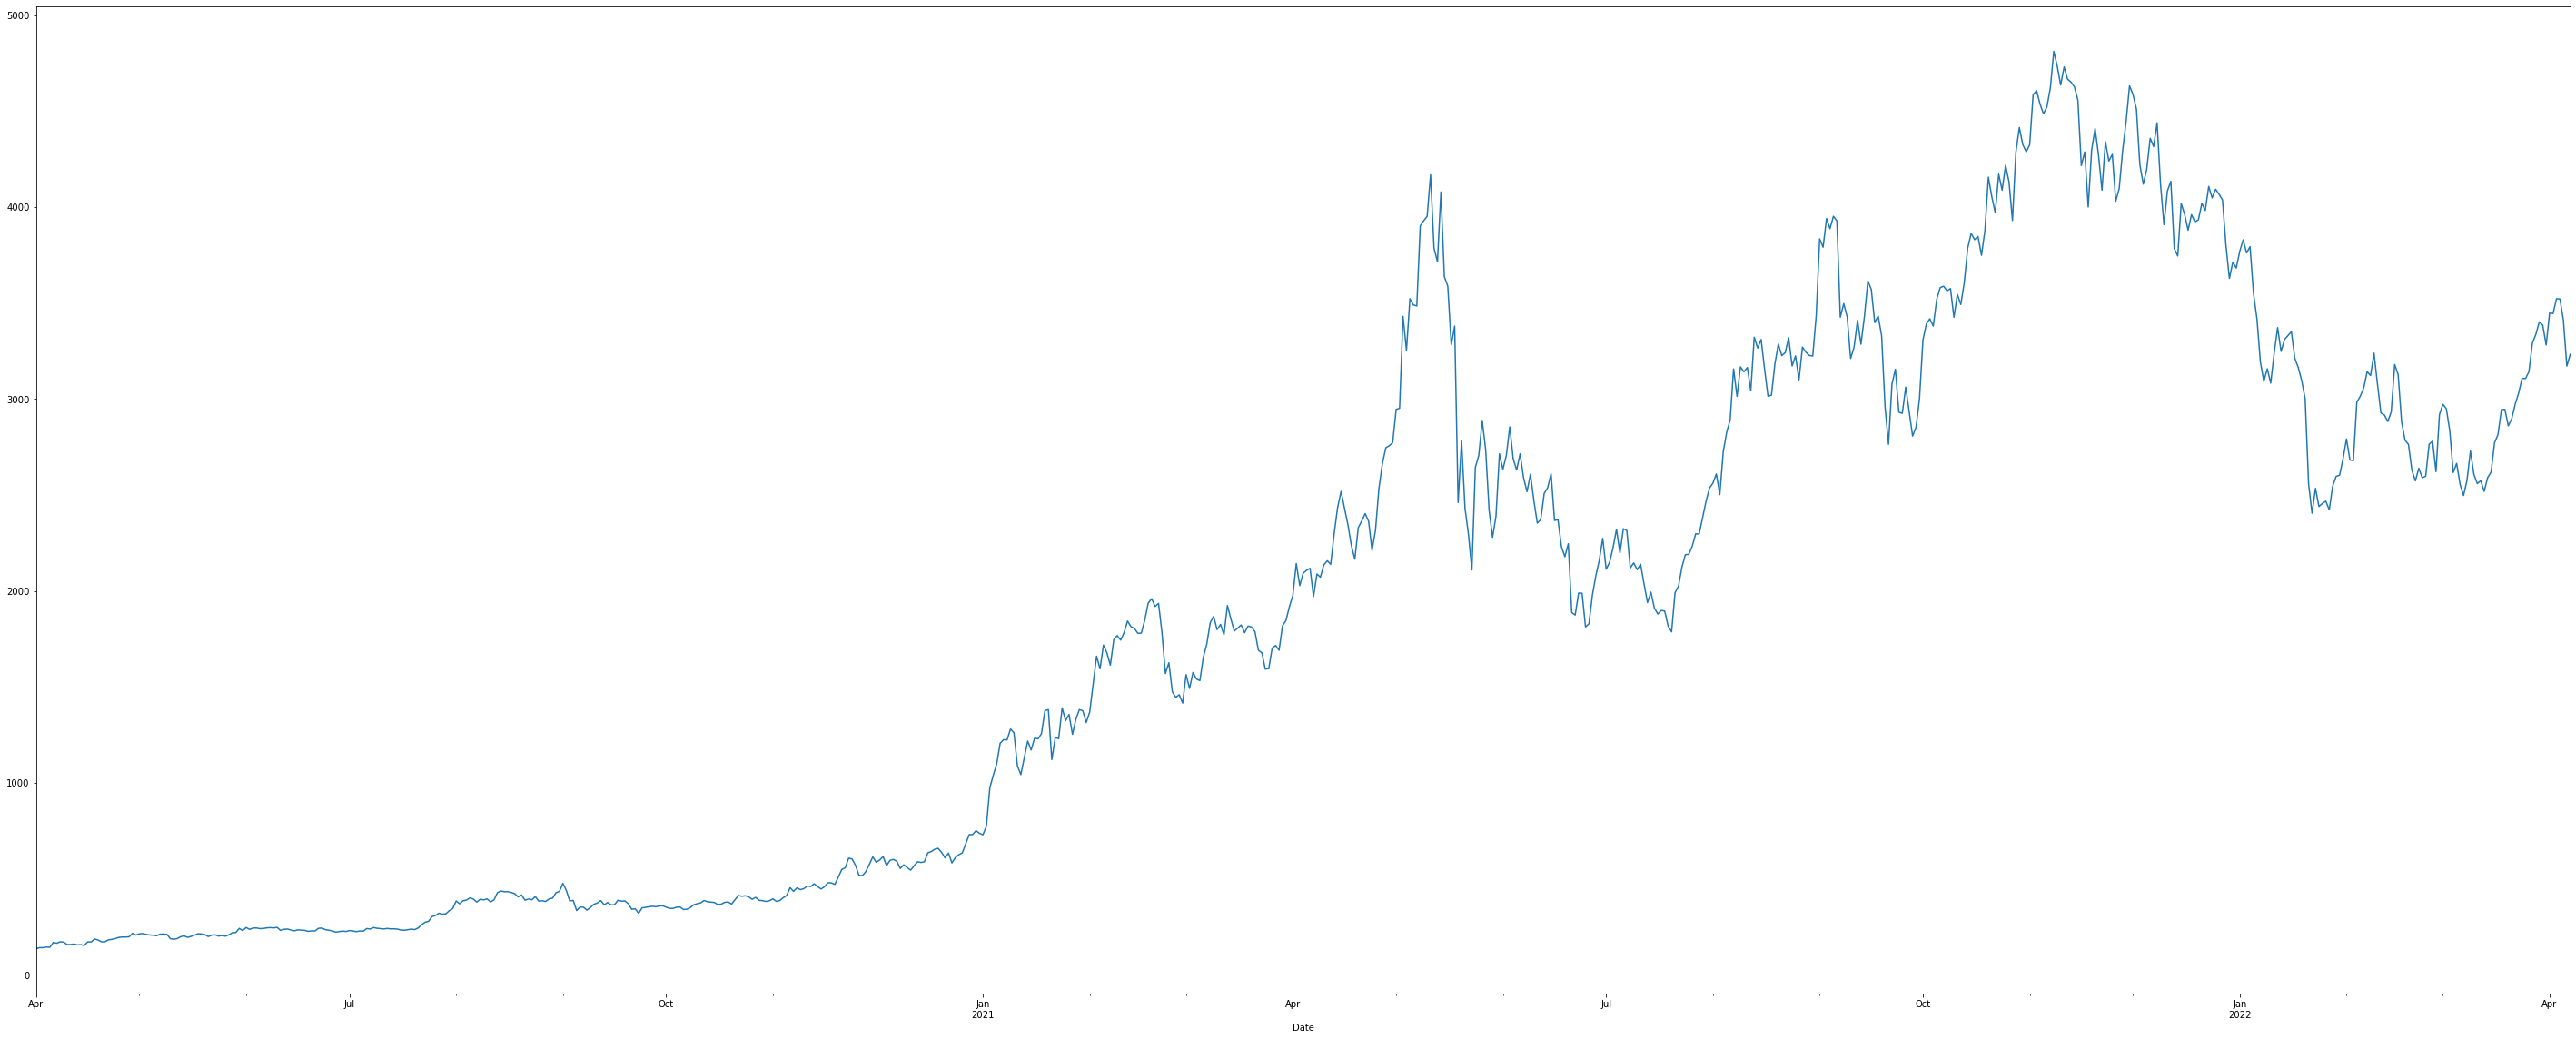

In [5]:
# Define target vector
y = df.Close
df.Close.plot(figsize=(50, 20))


In [6]:
# Splitting into Train and Test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [7]:
pd.DataFrame(y_test)

,Close
Date,
2021-08-29,3227.002686
2021-08-30,3224.374268
2021-08-31,3433.732666
2021-09-01,3834.828125
2021-09-02,3790.989990
...,...
2022-04-03,3522.833496
2022-04-04,3521.241211
2022-04-05,3411.792480


  ### Choose best learning rate

  ### Create Gradient Boosting Classifier

In [8]:
%%capture output

import warnings
warnings.filterwarnings('ignore')


from hpbandster_sklearn import HpBandSterSearchCV

param_distributions = {"max_depth": list(range(1, 10)), "learning_rate":[0,0.25,.5,.75,1]}
model = xgb.XGBRegressor(objective ='reg:linear')



search = HpBandSterSearchCV(model, param_distributions,random_state=0, n_jobs=1, n_iter=10, verbose=1).fit(X_train_scaled, y_train.ravel())
search.best_params_

[21:43:32] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:43:32] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:43:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "warm_start" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used

KeyboardInterrupt: 

In [9]:



# Choose a learning rate and create classifier
model = xgb.XGBRegressor(objective ='reg:linear', learning_rate = search.best_params_['learning_rate'],
                max_depth = search.best_params_['max_depth'], n_estimators = 100)

# Fit the model
model.fit(X_train_scaled, y_train.ravel())

# Make Prediction
predictions = model.predict(X_test_scaled)
pd.DataFrame({"Prediction": predictions, "Actual": y_test.ravel()}).head(20)

NameError: name 'search' is not defined

  ### Evaluate the model

In [ ]:
# Calculating the accuracy score
# acc_score = accuracy_score(y_test, predictions)
# print(f"Accuracy Score : {acc_score}")


stocks = pd.DataFrame({
    "Real": y_test.ravel(),
    "Predicted": predictions.ravel()
    }, index = df.index[-len(y_test): ])
stocks.head(100)



In [ ]:
stocks.plot(figsize=(50, 20))

In [ ]:
from sklearn import metrics

print(f'Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, predictions), 4))
print(f'Mean Squared Error:', round(metrics.mean_squared_error(y_test, predictions), 4))
print(f'Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 4))
print(f'(R^2) Score:', round(metrics.r2_score(y_test, predictions), 4))
errors = abs(predictions - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') 

Exception in thread discover_workers:
Traceback (most recent call last):
  File "/Users/manishrajkarnikar/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/Pyro4/core.py", line 515, in connect_and_handshake
    sslContext=sslContext)
  File "/Users/manishrajkarnikar/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/Pyro4/socketutil.py", line 307, in createSocket
    sock.connect(connect)
ConnectionRefusedError: [Errno 61] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/manishrajkarnikar/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/Pyro4/core.py", line 2009, in _locateNS
    proxy._pyroBind()
  File "/Users/manishrajkarnikar/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/Pyro4/core.py", line 408, in _pyroBind
    return self.__pyroCreateConnection(True)
  File "/Users/manishrajkarnikar/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/Pyro4/core.py", lin